# This notebook is to dump specific feature map

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
import os
import caffe
import time
import glob
import scipy
import csv
import itertools
from natsort import natsorted

In [2]:
# Set the csv limitation 
maxInt = sys.maxsize
decrement = True

while decrement:
    # decrease the maxInt value by factor 10 
    # as long as the OverflowError occurs.

    decrement = False
    try:
        csv.field_size_limit(maxInt)
    except OverflowError:
        maxInt = int(maxInt/10)
        decrement = True

In [3]:
def getfrombigtxt(fname, delimiter=' '):
    tmp = []
    with open(fname, 'r') as f: # note text mode, not binary
        for row in csv.reader(f):
            for elements in row[0].split(delimiter):
#                 tmp.append(map(float, elements))
                tmp.append((elements))
    del tmp[-1]
    return np.asarray(tmp,dtype=np.float32)

In [4]:
def caffe_inference(image_path, model_def = 'prototxt/yolo_tiny_deploy_6.prototxt'  , weight = 'weight/yolo_tiny.caffemodel'):
    
    # Configure
    pycaffe_dir = '/home/caslab/workspace/caffe/caffe/python/'
    model_dir = '/home/caslab/workspace/NVDLA/sw_6_1/prebuilt/linux/model/yolo'
    input_file = image_path
    model_def = os.path.join(model_dir,model_def)
    pretrained_model = os.path.join(model_dir, weight)
    gpu = False
    center_only = True
    images_dim = '448,448'
    mean_file = None
    # input_scale = 
    raw_scale = 255.0
    channel_swap = '2,1,0'
    ext = 'jpg'
    image_dims = [int(s) for s in images_dim.split(',')]
    mean, channel_swap_arr = None, None
    
    
    
    # Setup parameter
    if mean_file:
        mean = np.load(mean_file)
    if channel_swap:
        channel_swap_arr = [int(s) for s in channel_swap.split(',')]
    if gpu:
        caffe.set_mode_gpu()
    else:
        caffe.set_mode_cpu()

    
    # Create classifier class
    classifier = caffe.Classifier(model_def, pretrained_model,
            image_dims=image_dims, mean=mean,
            raw_scale=raw_scale,
            channel_swap=channel_swap_arr)


    
    # Load image file.
    inputs =[caffe.io.load_image(input_file)]
    load_img_time_end = time.time()

    # Classify
    predictions = classifier.predict(inputs, not center_only)
    
    return predictions[0]

In [5]:
# function is to show layer data by gray image
def show_data(data, padsize=1, padval=0, filename= 'test'):
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    plt.figure()
    plt.imshow(data,cmap='gray')
    # save image 
#     plt.savefig(filename +".png") 
    plt.axis('on')
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [6]:
def data_normalization(data):
    return (data - data.min()) / (data.max() - data.min())

In [7]:
image_path = '/home/caslab/workspace/NVDLA/sw_6_1/prebuilt/linux/image/dog448.jpg'
dimg_root_path = '/home/caslab/workspace/NVDLA/sw_6_1/prebuilt/linux/runtime/yolo_dimg_each_448/'
nvdla_feature_map_file = os.path.join(dimg_root_path,'yolo_tiny_deploy_6.prototxt.dimg')

caffe_feature =caffe_inference(image_path)
nvdla_result = getfrombigtxt(nvdla_feature_map_file)
nvdla_feature = nvdla_result.reshape(len(caffe_feature),len(caffe_feature[0]),-1)

----------------[000]--------------------
Caffe


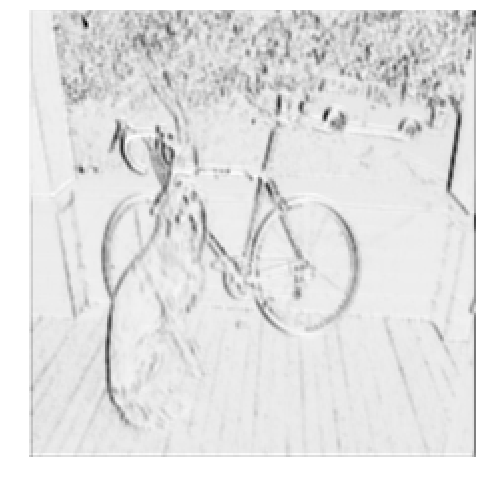

NVDLA


----------------[001]--------------------
Caffe


NVDLA


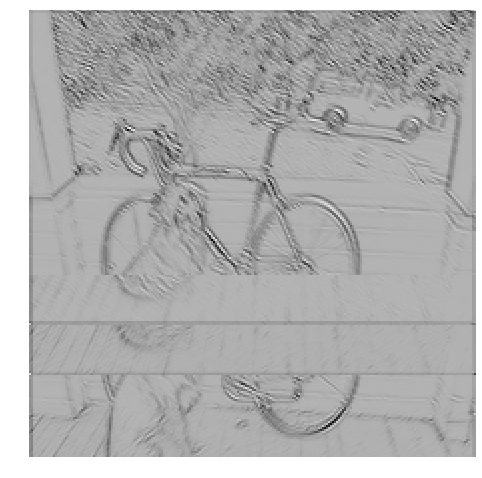

----------------[002]--------------------
Caffe


NVDLA


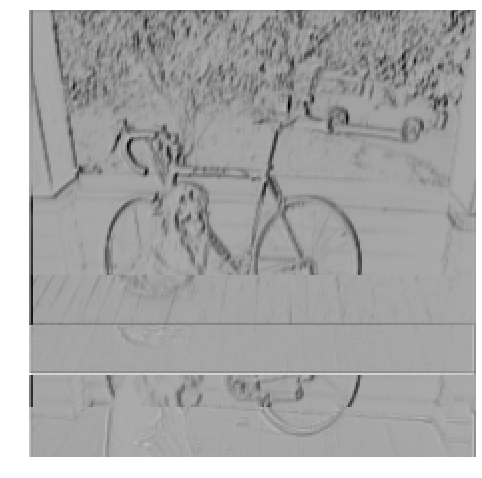

----------------[003]--------------------
Caffe


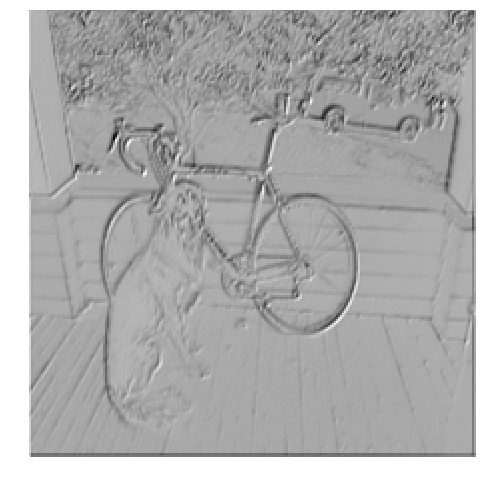

NVDLA


----------------[004]--------------------
Caffe


NVDLA


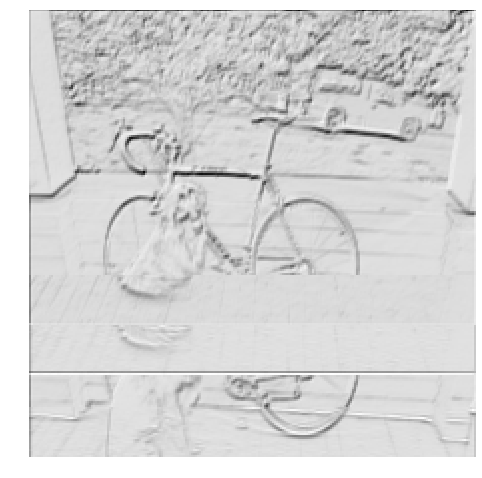

----------------[005]--------------------
Caffe


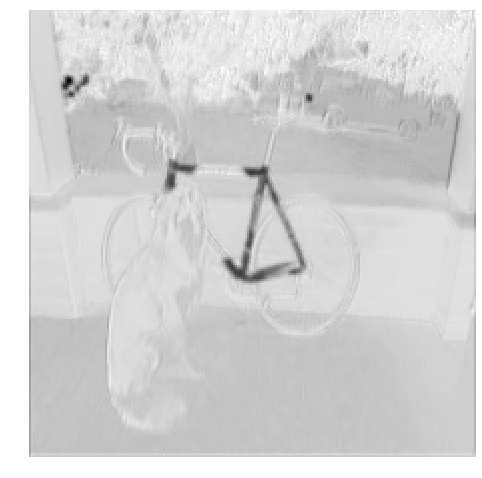

NVDLA


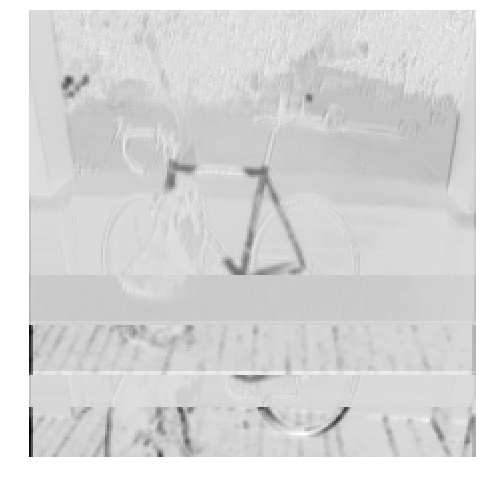

----------------[006]--------------------
Caffe


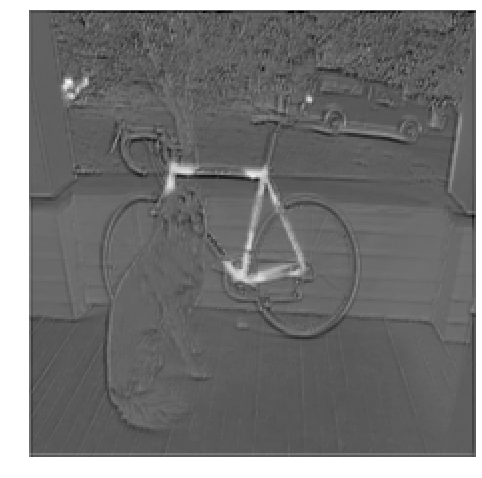

NVDLA


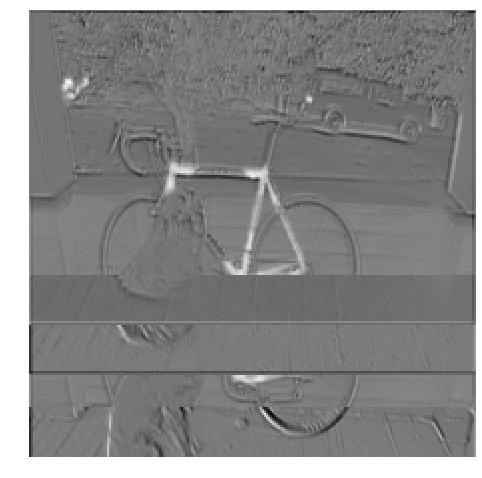

----------------[007]--------------------
Caffe


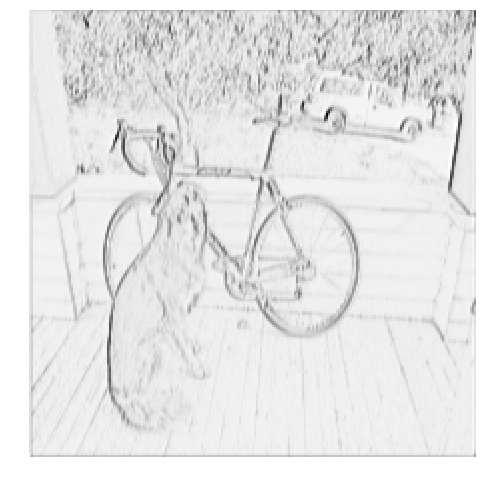

NVDLA


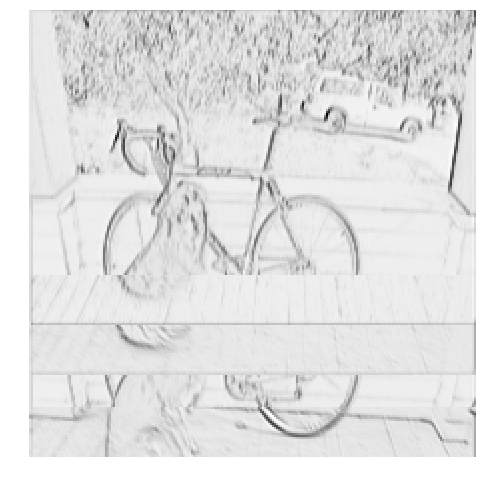

----------------[008]--------------------
Caffe


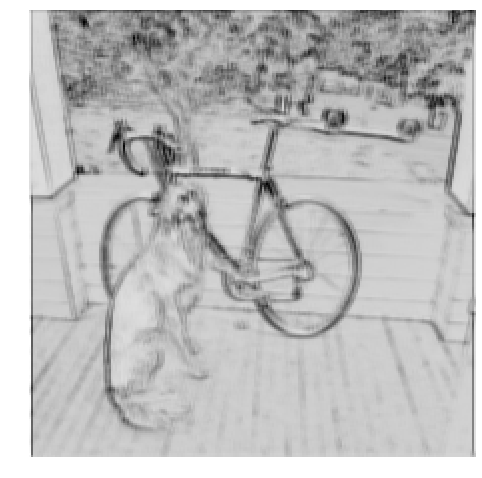

NVDLA


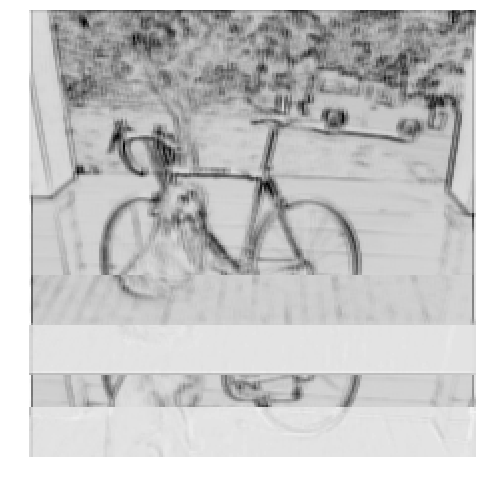

----------------[009]--------------------
Caffe


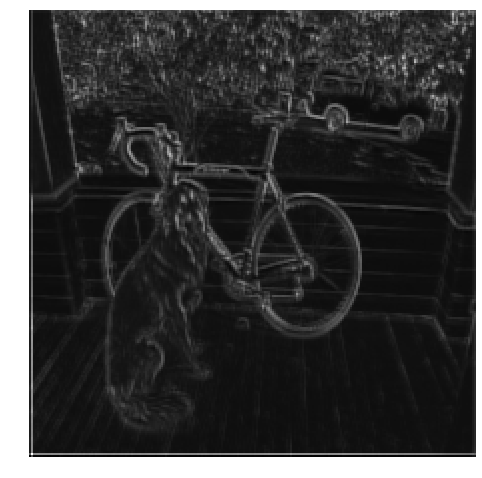

NVDLA


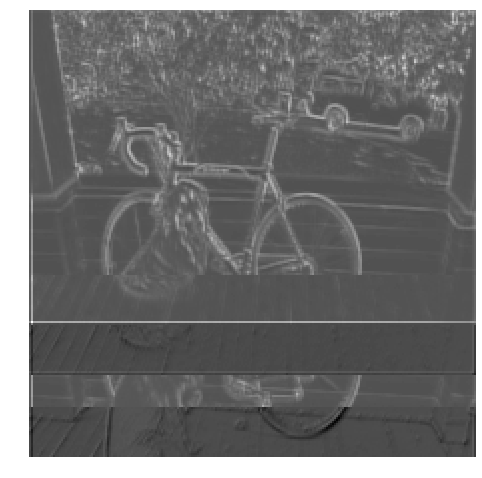

----------------[010]--------------------
Caffe


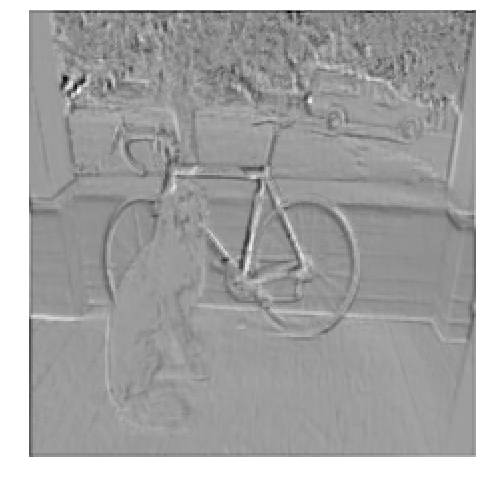

NVDLA


----------------[011]--------------------
Caffe


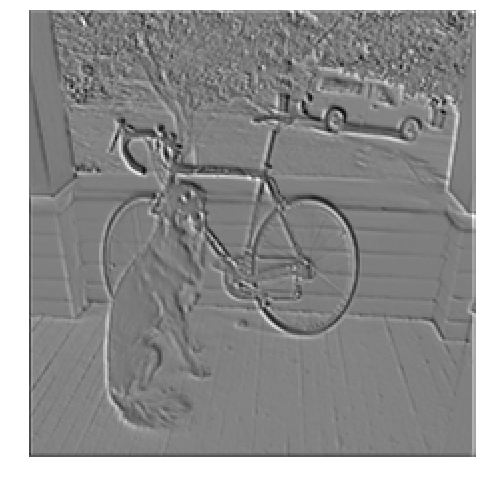

NVDLA


----------------[012]--------------------
Caffe


NVDLA


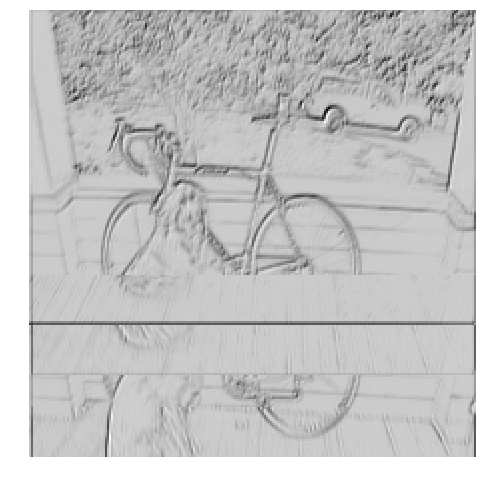

----------------[013]--------------------
Caffe


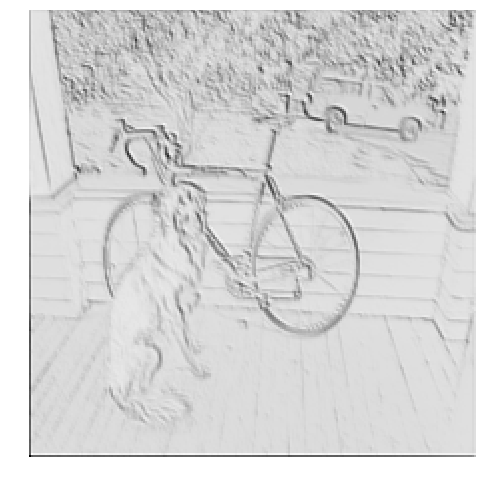

NVDLA


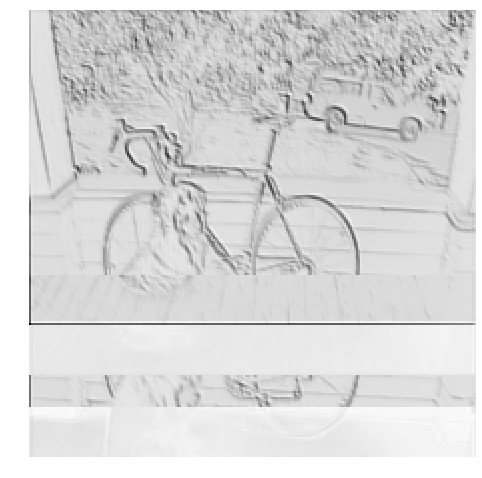

----------------[014]--------------------
Caffe


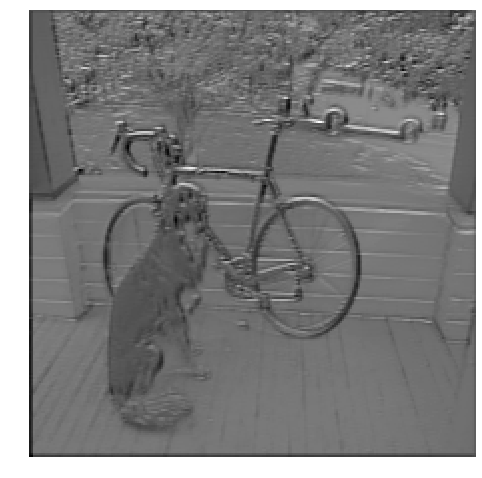

NVDLA


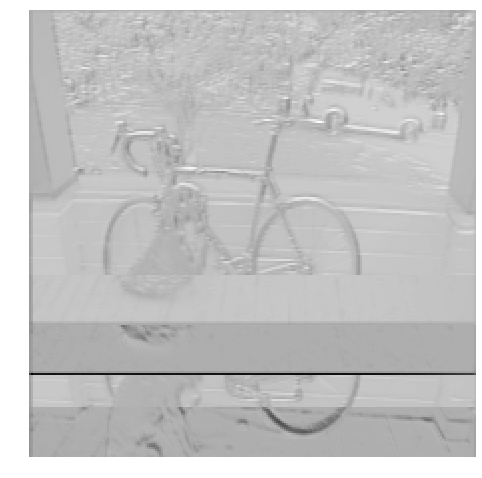

----------------[015]--------------------
Caffe


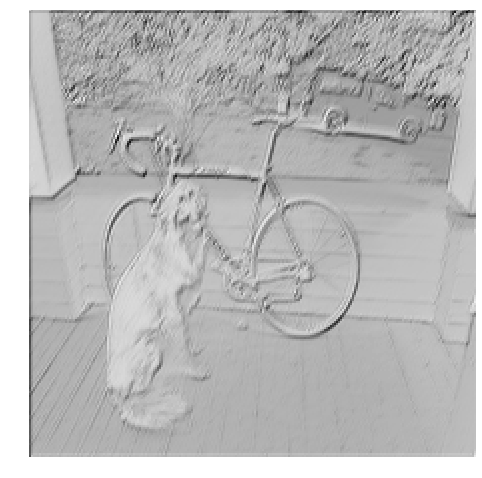

NVDLA


----------------[016]--------------------
Caffe


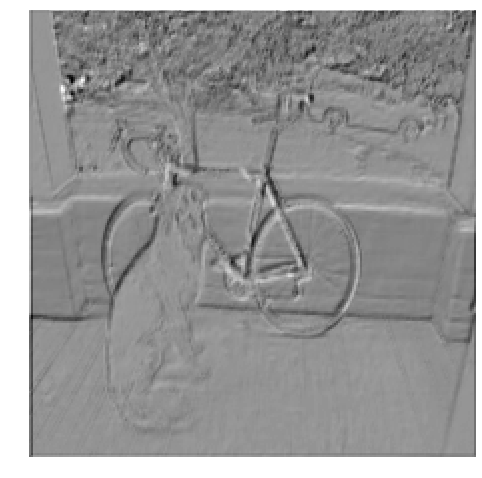

NVDLA


----------------[017]--------------------
Caffe


NVDLA


----------------[018]--------------------
Caffe


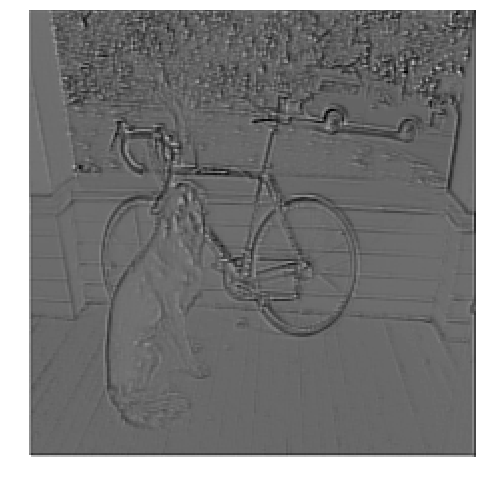

NVDLA


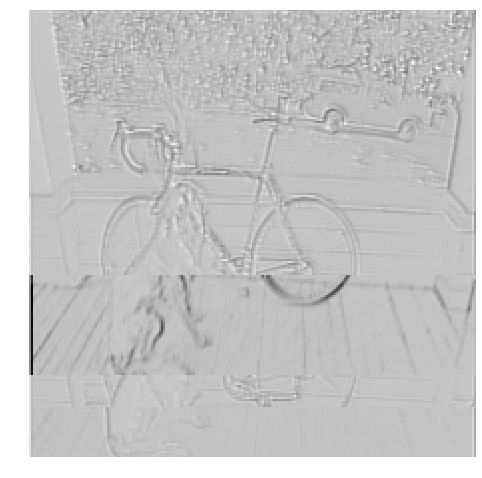

----------------[019]--------------------
Caffe


NVDLA


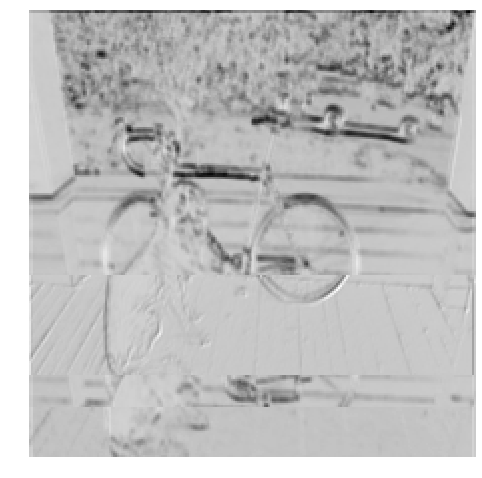

----------------[020]--------------------
Caffe


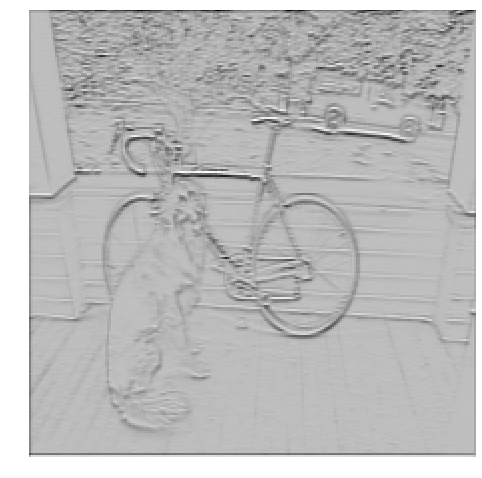

NVDLA


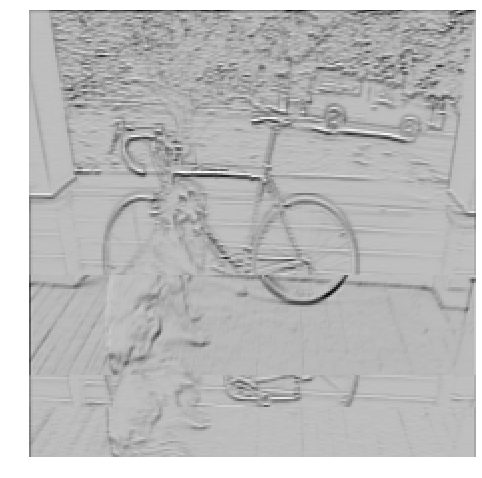

----------------[021]--------------------
Caffe


NVDLA


----------------[022]--------------------
Caffe


NVDLA


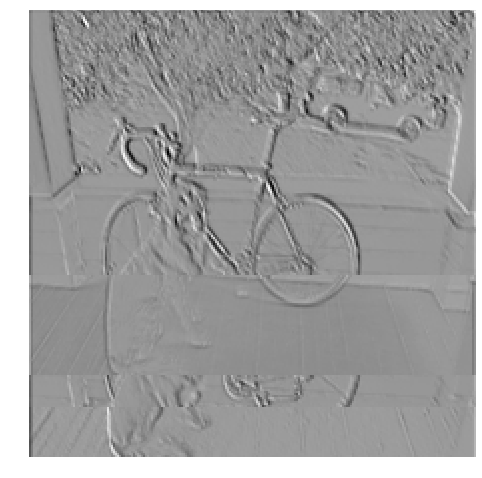

----------------[023]--------------------
Caffe


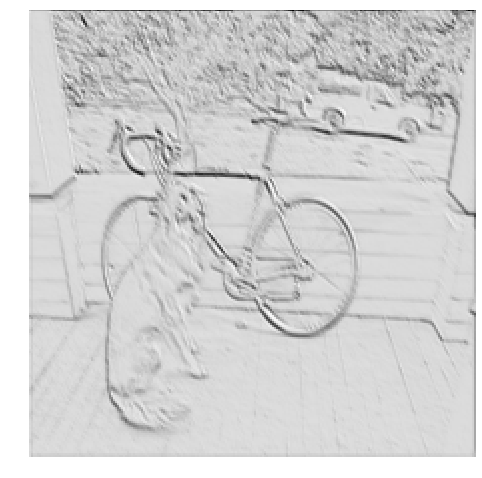

NVDLA


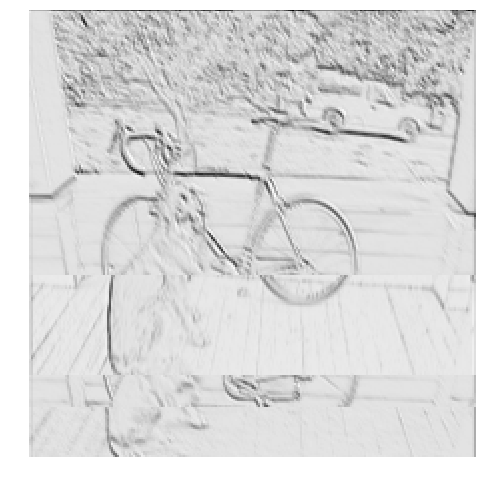

----------------[024]--------------------
Caffe


NVDLA


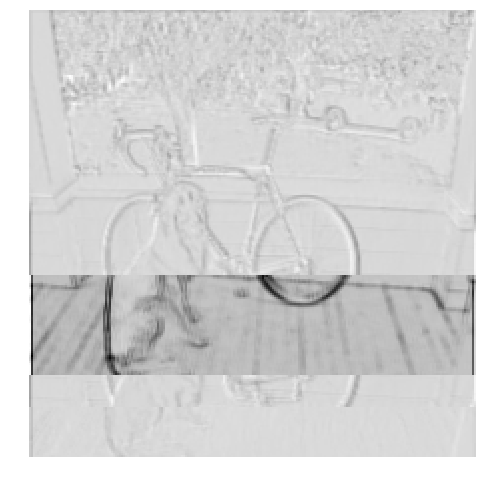

----------------[025]--------------------
Caffe


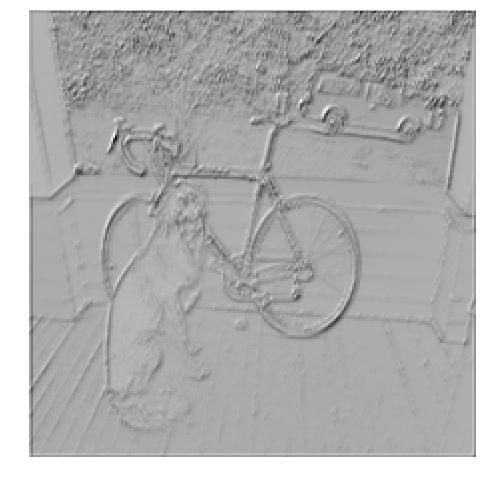

NVDLA


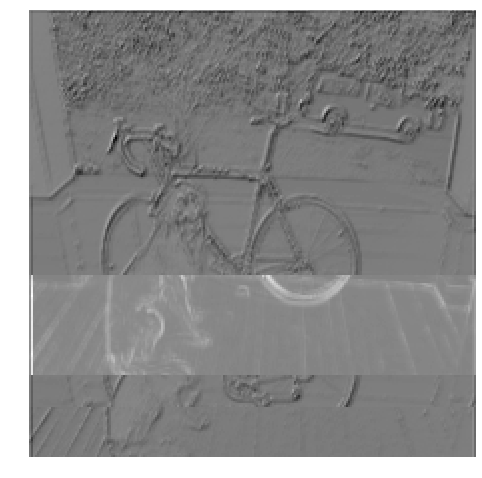

----------------[026]--------------------
Caffe


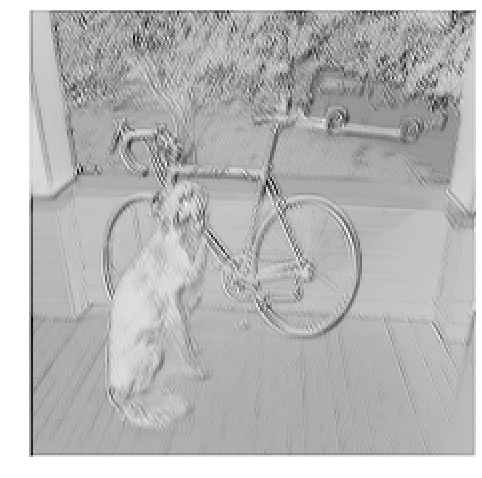

NVDLA


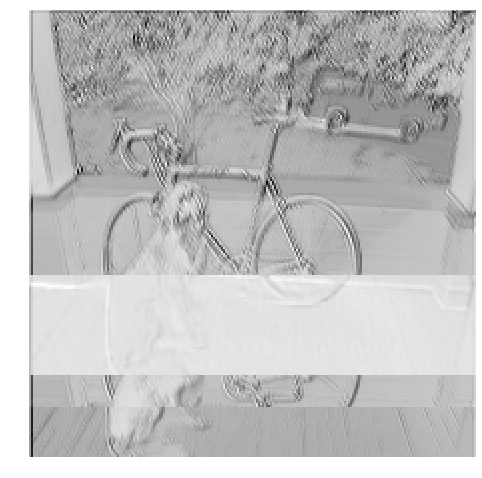

----------------[027]--------------------
Caffe


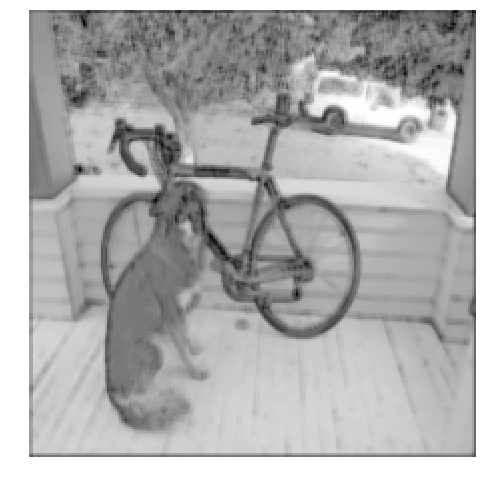

NVDLA


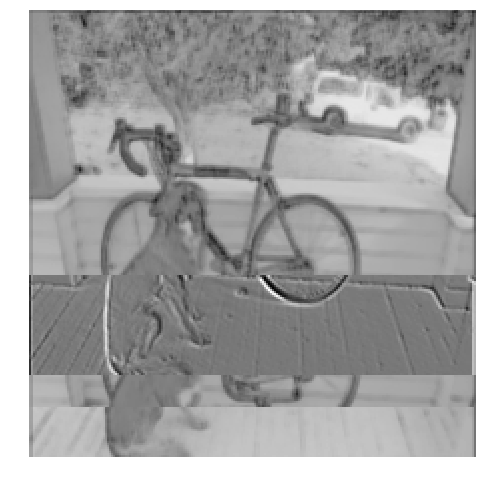

----------------[028]--------------------
Caffe


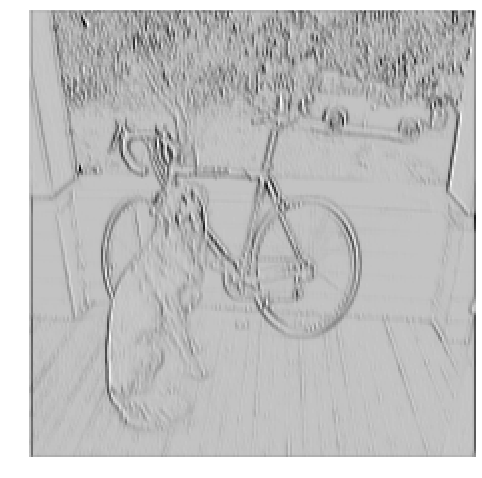

NVDLA


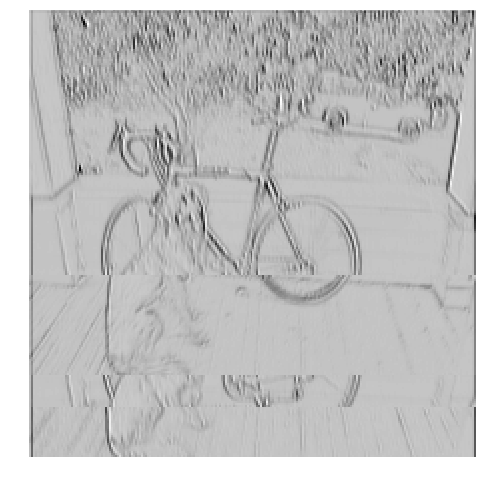

----------------[029]--------------------
Caffe


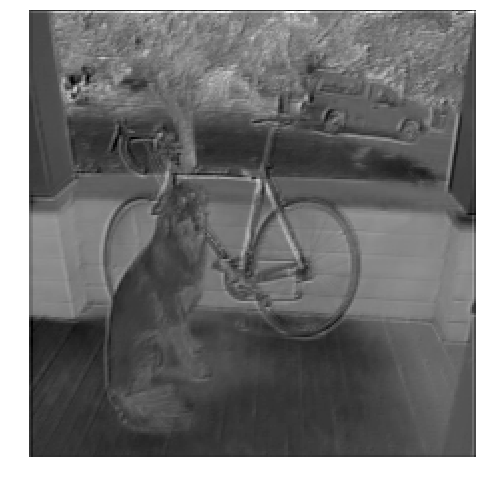

NVDLA


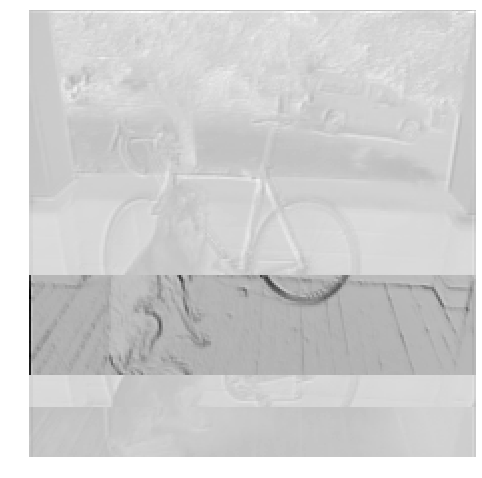

----------------[030]--------------------
Caffe


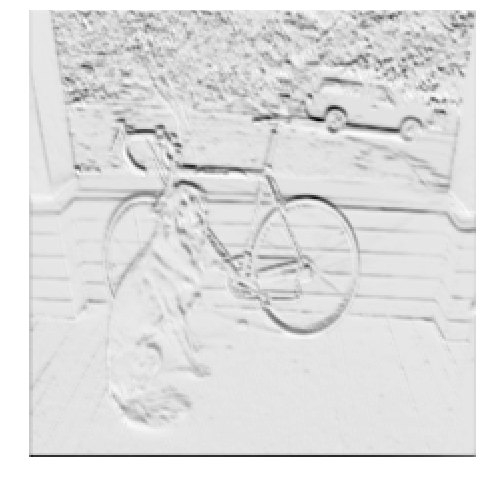

NVDLA


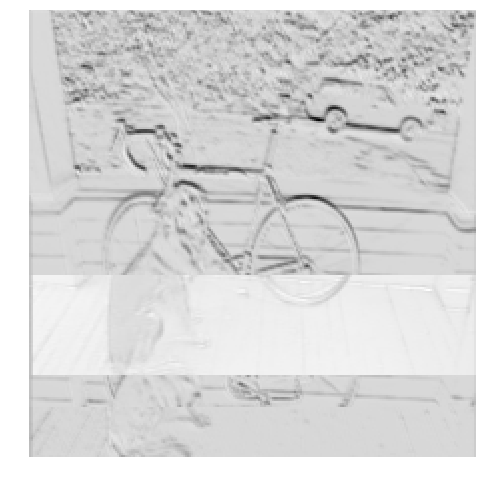

----------------[031]--------------------
Caffe


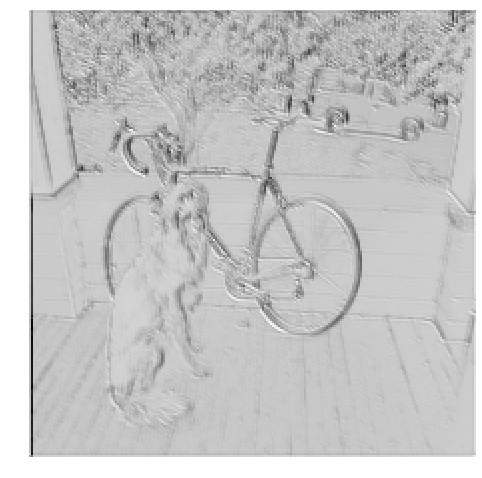

NVDLA


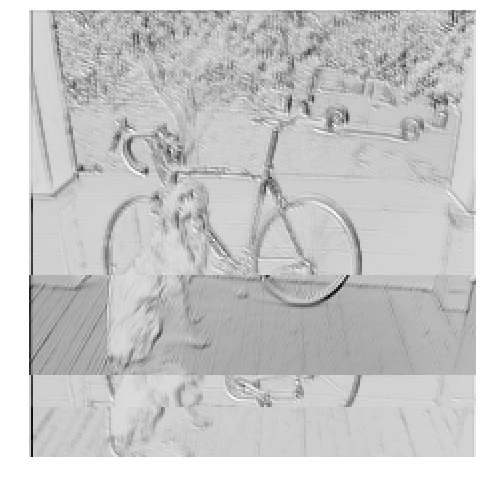

In [8]:
for i in range(0,len(nvdla_feature)):
    print("----------------[%03d]--------------------"%i)
    print("Caffe")
    norm_caffe_feature = data_normalization(caffe_feature)
    plt.figure()
    plt.imshow(norm_caffe_feature[i],cmap='gray')
    plt.axis('off')
    plt.rcParams['image.interpolation'] = 'nearest'
    plt.rcParams['image.cmap'] = 'gray'
    plt.show()
    print("NVDLA")
    norm_nvdla_feature = data_normalization(nvdla_feature)
    plt.figure()
    plt.imshow(norm_nvdla_feature[i],cmap='gray')
    plt.axis('off')
    plt.rcParams['image.interpolation'] = 'nearest'
    plt.rcParams['image.cmap'] = 'gray'
    plt.show()
    